# Soft Clustering

## Import Required Packages

In [1]:
import time
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

## Read Data

In [2]:
ieee = pd.read_csv("Data/IEEE-Computer-Science-2017.csv")
ieee["Combined_text"] = ieee["Title"] + ieee["Abstract"] + ieee["Keywords"]
raw = ieee["Combined_text"]
raw = raw.dropna()

## Data Preprocessing

In [20]:
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
import string
#Tokenize the text
def tokenize(text):

    #Create Stemmer
    #stemmer = PorterStemmer()
    stemmer = WordNetLemmatizer()

    #Remove irrelevant character
    text = re.sub(r"[^a-zA-Z]", ' ', text)

    #Tokenization
    tokens = word_tokenize(text)
    tokens = [i for i in tokens if i not in string.punctuation]

    #Stemming
    stems = stem_tokens(tokens, stemmer)
    return stems

#Stemming Function
def stem_tokens(t,s):
    stemmed=[]
    for item in t:
        # stemmed.append(s.stem(item))
        stemmed.append(s.lemmatize(item))
    return stemmed


# tfidf_vectorizer = CountVectorizer(stop_words='english', tokenizer=tokenize, min_df=50)
max_feature = 800
tfidf_vectorizer_auto = TfidfVectorizer(stop_words='english', tokenizer=tokenize, max_df=500, max_features=600)
tfidf_data = tfidf_vectorizer_auto.fit_transform(raw)
print tfidf_data.shape
tfidf_data.toarray()



(1483, 600)


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.04080061,  0.        ],
       [ 0.0625694 ,  0.        ,  0.        , ...,  0.04504443,
         0.0563764 ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.05041872, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## Word2Vector

In [21]:
import gensim
from nltk import sent_tokenize, word_tokenize
import nltk
from nltk.corpus import stopwords

stops = set(stopwords.words('english'))

stemmer = WordNetLemmatizer()
# stemmer = PorterStemmer()
sentences = []
paper_list = []
for paper in raw:
    word_list = []
    for sent in sent_tokenize(paper.decode('utf-8')):
        words = word_tokenize(sent)
        # sentences.append([stemmer.stem(word.lower()) for word in words if word not in string.punctuation])
        sentences.append([stemmer.lemmatize(word.lower()) for word in words if word not in string.punctuation and word not in stops and not word.isdigit()])
        word_list += words
    paper_list.append(word_list)
word2vec_model = gensim.models.Word2Vec(sentences, size=600, window=5, min_count=20, workers=4, iter=20)


In [22]:


for i in range(len(paper_list)):
    new_list = []
    for word in paper_list[i]:
        if word.lower() not in stops:
            new_list.append(word)
    paper_list[i] = new_list

In [23]:
tfidf_vectorizer = TfidfVectorizer(tokenizer = tokenize)
tfidf_data = tfidf_vectorizer.fit_transform(raw)

In [24]:
paper_vector = []
paper_count = 0
for paper in paper_list:
    vector = np.zeros(600)
    diviser = 0
    for word in paper:
        if word in word2vec_model and word in tfidf_vectorizer.vocabulary_:
            tfidf_value = tfidf_data[paper_count,tfidf_vectorizer.vocabulary_[word]]
            diviser += tfidf_value
            vector += word2vec_model[word]*tfidf_value
    paper_vector.append(vector / diviser)
    paper_count += 1

/Users/ziaochen/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/Users/ziaochen/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [25]:
data_word2vec = np.array(paper_vector)
data_word2vec.shape

(1483, 600)

In [26]:
data_word2vec

array([[ 0.051262  ,  0.18776053, -0.21246379, ...,  0.07438911,
         0.16694102,  0.15134414],
       [ 0.07464364,  0.168325  , -0.05701352, ...,  0.24714081,
        -0.14169653, -0.04533141],
       [-0.09122151, -0.03345971, -0.03062254, ...,  0.08358278,
        -0.02868354,  0.08867132],
       ..., 
       [-0.11359027, -0.03897651,  0.00857415, ...,  0.27134921,
         0.04907611,  0.0281332 ],
       [ 0.11653225,  0.03236656, -0.16910964, ...,  0.09547054,
         0.04369414,  0.08924344],
       [ 0.04673484,  0.04940307, -0.14017919, ...,  0.12561755,
         0.04085545,  0.12938539]])

## Autoencoder

In [53]:
import pylab
import theano
import theano.tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
import os

WARNING (theano.configdefaults): Only clang++ is supported. With g++, we end up with strange g++/OSX bugs.
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


In [54]:
def init_weights(n_visible, n_hidden):
    initial_W = np.asarray(
        np.random.uniform(
            low=-4 * np.sqrt(6. / (n_hidden + n_visible)),
            high=4 * np.sqrt(6. / (n_hidden + n_visible)),
            size=(n_visible, n_hidden)),
        dtype=theano.config.floatX)
    return theano.shared(value=initial_W, name='W', borrow=True)

def init_bias(n):
    return theano.shared(value=np.zeros(n,dtype=theano.config.floatX),borrow=True)

In [123]:
x = T.fmatrix('x')  
d = T.fmatrix('d')


rng = np.random.RandomState(123)
theano_rng = RandomStreams(rng.randint(2 ** 30))


training_epochs = 200
learning_rate = 0.1
batch_size = 16
first_dimension = min(50,int(max_feature*0.7))
# second_dimension = 50

W1 = init_weights(tfidf_data.shape[1], first_dimension)
b1 = init_bias(first_dimension)
b1_prime = init_bias(tfidf_data.shape[1])
W1_prime = W1.transpose() 
# W2 = init_weights(first_dimension, second_dimension)
# b2 = init_bias(second_dimension)
# W2_prime = W2.transpose()
# b2_prime = init_bias(first_dimension)

y1 = T.nnet.sigmoid(T.dot(x, W1) + b1)
# y2 = T.nnet.sigmoid(T.dot(y1,W2) + b2)
# z2 = T.nnet.sigmoid(T.dot(y2, W2_prime) + b2_prime)
z1 = T.nnet.sigmoid(T.dot(y1, W1_prime) + b1_prime)
cost1 = T.sum((x-z1)**2)

params1 = [W1, b1, b1_prime]
grads1 = T.grad(cost1, params1)
updates1 = [(param1, param1 - learning_rate * grad1)
           for param1, grad1 in zip(params1, grads1)]
train_da1 = theano.function(inputs=[x], outputs = cost1, updates = updates1, allow_input_downcast = True)
test = theano.function(inputs=[x], outputs = y1, allow_input_downcast = True)
upsampling = theano.function(inputs=[y1], outputs = z1, allow_input_downcast = True)

In [124]:
print('training dae1 ...')
d = []
for epoch in range(training_epochs):
    # go through trainng set
    c = []
    for start, end in zip(range(0, tfidf_data.shape[0], batch_size), range(batch_size, tfidf_data.shape[0], batch_size)):
        c.append(train_da1(tfidf_data.toarray()[start:end]))
    d.append(np.mean(c, dtype='float64') / batch_size)
    print(d[epoch])

training dae1 ...
2.81372889943
0.938533686517
0.935897322708
0.934292089702
0.932874402311
0.931305809726
0.929279202763
0.926574815161
0.923542339562
0.92093263833
0.918838786384
0.916903161026
0.91482881625
0.912435098219
0.909649132539
0.906519033168
0.903150249281
0.899569825896
0.895685512164
0.891494068704
0.887245851225
0.883058538235
0.878887300092
0.874775939124
0.870751638274
0.866745154619
0.862680453923
0.858520306262
0.854261541528
0.850041971324
0.846087405964
0.842436761954
0.838972522607
0.835582436528
0.832209233066
0.82883555787
0.825462372455
0.822096953161
0.81874764056
0.815418283878
0.812101128564
0.808771857753
0.805389413455
0.801900476543
0.798250639758
0.794406312542
0.790374188493
0.786178800299
0.781809049277
0.777219641459
0.77240697014
0.767470727669
0.762575706272
0.757857029171
0.753367777085
0.749095298691
0.744997596217
0.741016595626
0.737077041629
0.73309262727
0.728982442402
0.724698156062
0.720261310675
0.715781414353
0.71141064714
0.707261051466


In [66]:
data = test(tfidf_data.toarray())
print data

[[ 0.79119289  0.21104235  0.55880483 ...,  0.70685674  0.02187131
   0.26534901]
 [ 0.52292467  0.62275458  0.40969103 ...,  0.27858279  0.01665859
   0.67977598]
 [ 0.7399837   0.38220733  0.45604365 ...,  0.13080241  0.01343907
   0.42152503]
 ..., 
 [ 0.40882439  0.68291476  0.30476679 ...,  0.49719277  0.01499242
   0.39519157]
 [ 0.43642496  0.44110755  0.29942032 ...,  0.44078169  0.0124258
   0.47495906]
 [ 0.50832936  0.28121095  0.16326793 ...,  0.23035646  0.00860837
   0.28306392]]


## Topic Tree Class

In [92]:
"Tiger".lower()

'tiger'

In [2]:
import requests
class TopicTree:
    def __init__(self, level=0, index=1, children=[], keywords=[], n_top_words=10):
        self.children = children
        self.keywords = keywords
        self.level = level
        self.index = index
        self.dup_index = 0
        self.association_index = 0
        self.base_url = 'https://api.wordassociations.net/associations/v1.0/json/search?apikey=85618aa1-21c2-4382-9dc6-373c5b1424b8&lang=en&limit=100'
        self.n_top_words = n_top_words
    
    def get_number_of_children(self):
        return len(self.children)

    def get_children(self):
        return children
    
    def get_topic_content(self):
        return self.topic_content

    def compute_dup_index(self):
        if not self.children:
            return
        children_keywords = []
        for child in self.children:
            children_keywords += child.keywords
            child.compute_dup_index()
        original_len = len(children_keywords)
        children_keywords = list(set(children_keywords))
        num_of_duplicate = original_len - len(children_keywords)
        self.dup_index = float(num_of_duplicate) / original_len
        
    def get_whole_tree_dup_index(self):
        if self.dup_index == 0:
            self.compute_dup_index()
        if not self.children:
            return self.dup_index
        children_index = 0
        for child in self.children:
            children_index += child.get_whole_tree_dup_index()
        return (self.dup_index + children_index) / float(1 + len(self.children))
    
    def compute_association_index(self):
        base_url = self.base_url
        word_sum = 0
        if len(self.keywords) <= 10:
            for word in self.keywords:
                base_url = base_url + '&text=' + word
            response = requests.get(base_url).json()['response']
        elif len(self.keywords) <= 20:
            for word in self.keywords[:10]:
                base_url = base_url + '&text=' + word
            response = requests.get(base_url).json()['response']
            base_url = self.base_url
            for word in self.keywords[10:]:
                base_url = base_url + '&text=' + word
            response = response + requests.get(base_url).json()['response']
        else:
            for word in self.keywords[:10]:
                base_url = base_url + '&text=' + word
            response = requests.get(base_url).json()['response']
            base_url = self.base_url
            for word in self.keywords[10:20]:
                base_url = base_url + '&text=' + word
            response = response + requests.get(base_url).json()['response']
            base_url = self.base_url
            for word in self.keywords[20:]:
                base_url = base_url + '&text=' + word
            response = response + requests.get(base_url).json()['response']
        for word_json in response:
            items = word_json['items']
            for item in items:
                if item['item'].lower() in self.keywords:
                    word_sum += float(item['weight']) / 100.0
        self.association_index = float(word_sum) / self.n_top_words / (self.n_top_words - 1)
    
    def get_whole_tree_association_index(self):
        if self.association_index == 0:
            self.compute_association_index()
        if not self.children:
            return self.association_index
        children_index = 0
        for child in self.children:
            children_index += float(child.get_whole_tree_association_index())
        # children_index = children_index / len(self.children)
        return (self.association_index + children_index) / float(1 + len(self.children))
            
            

## Hierarchical Soft Clustering Class

In [20]:
class FuzzyClustering:
    
    def __init__(self,data_dim_red, weight_vector, dictionary, epochs=50, num_topic_range=10,m=2, word2vec=False):
        self.epochs = epochs
        self.num_topic_range = num_topic_range
        self.m = m
        self.pre_cost = 100000000
        self.weight_vector = weight_vector
        self.dictionary = dictionary
        self.word2vec = word2vec
        self.data_dim_red = data_dim_red
        
    def get_silhouette_coefficient(self):
        num_doc = self.data.shape[0]
        num_topic = self.doc_topic_weight_mat.shape[1]
        topic_format_data_list=[]
        for topic_index in range(num_topic):
            topic_format_data_list.append(((self.data.T)*self.doc_topic_weight_mat[:,topic_index]).T)  
        sil_coe_all = 0
        
    
        for doc_index in range(num_doc):
            for topic_index in range(num_topic):
                doc = topic_format_data_list[topic_index][doc_index]
                a = np.mean(np.linalg.norm(topic_format_data_list[topic_index] - doc, axis=1))
                b = np.finfo(float).max
                sil_coe = -1
                for topic_index2 in range(num_topic):
                    if topic_index2 != topic_index:
                        b = min(b, np.mean(np.linalg.norm(topic_format_data_list[topic_index2] - doc, axis=1)))
                sil_coe = max(sil_coe, (b - a) / max(a,b))
            sil_coe_all += sil_coe
        return sil_coe_all / num_doc
    
    def get_MPC(self):
        num_doc = self.doc_topic_weight_mat.shape[0]
        num_topic = self.doc_topic_weight_mat.shape[1]
        pc = np.sum(np.square(self.doc_topic_weight_mat)) / num_doc
        if num_topic == 1:
            mpc = 0.90
        else:
            mpc = 1 - float(num_topic) / (num_topic - 1) * (1 - pc)
        return mpc
    
    def do_clustering(self,doc_word_mat, num_cluster=0, num_topic=10, exp=False):
        num_doc = doc_word_mat.shape[0]
        doc_topic_weight_mat = self.initialize_weight_mat(num_doc,num_topic)
        centroids = self.initialize_centroid(doc_word_mat, num_topic)
        self.pre_cost = 1000000000
        for epoch in range(self.epochs):
            doc_topic_weight_mat = self.update_weight_mat(doc_word_mat, doc_topic_weight_mat, centroids, exp) 
            cost = self.get_cost(doc_word_mat, doc_topic_weight_mat, centroids)
            # print cost
            if cost > self.pre_cost:
                self.data = doc_word_mat
                self.doc_topic_weight_mat = doc_topic_weight_mat
                self.centroids = centroids
                return doc_topic_weight_mat, centroids
            self.pre_cost = cost
            centroids = self.compute_centroid(doc_word_mat, doc_topic_weight_mat)
        # doc_topic_weight_mat = (doc_topic_weight_mat.T / doc_topic_weight_mat.sum(axis=1)).T
        self.data = doc_word_mat
        self.doc_topic_weight_mat = doc_topic_weight_mat
        self.centroids = centroids
        return doc_topic_weight_mat, centroids
                
        
    def compute_centroid(self, doc_word_mat, doc_topic_weight_mat):
        num_cen = doc_topic_weight_mat.shape[1]
        num_word = doc_word_mat.shape[1]
        
        centroids = np.zeros((num_cen, num_word))
        for cen_index in range(num_cen):
            centroids[cen_index] = np.dot(np.power(doc_topic_weight_mat.T[cen_index], self.m)*self.weight_vector, doc_word_mat) / np.sum(np.power(doc_topic_weight_mat.T[cen_index],self.m)*self.weight_vector)
        return centroids
    
    def initialize_centroid(self, doc_word_mat, num_topic):
        return doc_word_mat[np.random.randint(0,doc_word_mat.shape[0],num_topic),:] + 0.0001
    
    def initialize_weight_mat(self,row,col):
        # return np.random.uniform(low=0, high=2.0/col, size=(row,col))
        return np.full((row,col),1.0/col, dtype=float)
    
    def update_weight_mat(self,doc_word_mat, doc_topic_weight_mat, centroids, exp=False):
        num_doc = doc_topic_weight_mat.shape[0]
        num_topic = doc_topic_weight_mat.shape[1]
        
        if exp:
            doc_topic_distance = np.zeros((num_doc, num_topic))
            for topic_index in range(num_topic):
                Fk = np.zeros((doc_word_mat.shape[1], doc_word_mat.shape[1]))
                Fk_diviser = np.sum(doc_topic_weight_mat[:,topic_index]*self.weight_vector)
                
                for doc_index in range(num_doc):
                    Fk += doc_topic_weight_mat[doc_index][topic_index]*self.weight_vector[doc_index]*np.outer(centroids[topic_index] - doc_word_mat[doc_index], centroids[topic_index] - doc_word_mat[doc_index])
                Fk = Fk/Fk_diviser
                Fk_determiner = np.linalg.det(Fk)**0.5
                Fk_inverse = np.linalg.inv(Fk)
                ak = np.sum(doc_topic_weight_mat[:,topic_index]) / np.sum(self.weight_vector)
                for doc_index in range(num_doc):
                    difference = centroids[topic_index] - doc_word_mat[doc_index]
                    doc_topic_distance[doc_index][topic_index] = Fk_determiner / ak*np.exp(np.dot(np.dot(difference, Fk_inverse),difference/2))
                    
            
            for doc_index in range(num_doc):
                dist_to_all_clusters = np.sum(doc_topic_distance[doc_index]) + np.finfo(float).eps
                for topic_index in range(num_topic):
                    doc_topic_weight_mat[doc_index][topic_index] = np.power(doc_topic_distance[doc_index][topic_index] / dist_to_all_clusters, 2.0/(self.m-1))
            
        else:
            for doc_index in range(num_doc):
                dist_to_all_cluster = np.linalg.norm(centroids - doc_word_mat[doc_index], axis=1)

                new_weight = np.zeros(num_topic)
                for topic_index in range(num_topic):

                    new_weight += np.power(dist_to_all_cluster / (np.linalg.norm(centroids[topic_index] - doc_word_mat[doc_index])+np.finfo(float).eps),2.0/(self.m-1))
                    # new_weight += np.power(dist_to_all_cluster / (1-np.sum(centroids[topic_index] * doc_word_mat[doc_index])/ np.linalg.norm(centroids[topic_index]) / np.linalg.norm(doc_word_mat[doc_index])),2/(self.m-1))

                doc_topic_weight_mat[doc_index] = 1.0 / new_weight
           
        
        return doc_topic_weight_mat
    
    def get_cost(self, doc_word_mat, doc_topic_weight_mat, centroids):
        cost = 0
        num_doc = doc_topic_weight_mat.shape[0]
        num_topic = doc_topic_weight_mat.shape[1]
        
        for doc_index in range(num_doc):
            for topic_index in range(num_topic):
                cost += doc_topic_weight_mat[doc_index, topic_index]**self.m *self.weight_vector[doc_index]* np.linalg.norm(centroids[topic_index] - doc_word_mat[doc_index])
                # cost += doc_topic_weight_mat[doc_index, topic_index]**self.m * (1-np.sum(centroids[topic_index] * doc_word_mat[doc_index])/ np.linalg.norm(centroids[topic_index]) / np.linalg.norm(doc_word_mat[doc_index]))
        return cost

    def print_top_words(self,n_top_words, topics, feature_names):
        n_top_words = 10
        topic_idx = 0
        if self.word2vec:
            for topic in topics:
                topic_words = [x[0] for x in self.data_dim_red.word2vec_model.wv.similar_by_vector(topic, topn=n_top_words)]
                # topic_words.sort()
                topic_idx += 1
                message = "Topic %d: " % topic_idx
                message += " ".join(topic_words)
                print message
        else:
            topics = self.data_dim_red.upsampling_auto(topics)
            for topic in topics:
                topic_idx += 1
                message = "Topic %d: " % topic_idx
                topic_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
                message += " ".join(topic_words)
                print message
    
    def get_top_words(self, level, n_top_words, topics, feature_names):
        children = []
        topic_idx = 0
        if self.word2vec:
            for topic in topics:
                topic_words = [x[0] for x in self.data_dim_red.word2vec_model.wv.similar_by_vector(topic, topn=n_top_words)]
                topic_idx += 1
                children.append(TopicTree(level=level, index=topic_idx, keywords=topic_words, n_top_words=n_top_words))
                
        else:
            topics = self.data_dim_red.upsampling_auto(topics)
            for topic in topics:
                topic_idx += 1
                topic_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
                children.append(TopicTree(level=level, index=topic_idx, keywords=topic_words, n_top_words=n_top_words))
        return children
                

In [4]:
class Hierarchical_Fuzzy_Clustering:
    def __init__(self,data_dim_red, word2vec=False, max_level=3,epochs=10, m=2, max_topic=5, n_top_words=10):
        self.max_level = max_level
        self.m = m
        self.max_topic = max_topic
        self.epochs = epochs
        self.topic_tree = TopicTree(level=1, index=1)
        self.current_tree = self.topic_tree
        self.n_top_words = n_top_words
        self.data_dim_red = data_dim_red
        self.word2vec = word2vec
        if word2vec:
            self.dictionary = data_dim_red.tfidf_vectorizer_word2vec.get_feature_names()
            self.data = data_dim_red.word2vec_data
        else:
            self.dictionary = data_dim_red.tfidf_vectorizer_auto.get_feature_names()
            self.data = data_dim_red.auto_data
        
    
    def do_hierarchical_clustering(self,weight_vector, level=1,topic_index=1):
        
        if level==1:
            self.build_root()
            
        if level > self.max_level:
            return
        
        print "\nlevel %d topic %d" %(level, topic_index)
        model = FuzzyClustering(data_dim_red = self.data_dim_red, dictionary=self.dictionary, weight_vector=weight_vector, epochs=self.epochs, m=self.m, word2vec=self.word2vec)
        target_MPC = 0
        target_doc_topic_weight_matrix = np.array([])
        target_topics = np.array([])
        for num_topic in range(1,self.max_topic+1): 
            doc_topic_weight_matrix, topics = model.do_clustering(self.data, num_topic=num_topic)
            MPC = model.get_MPC()
            if MPC > target_MPC:
                target_MPC = MPC
                target_doc_topic_weight_matrix = doc_topic_weight_matrix
                target_topics = topics
            
        num_topics = target_doc_topic_weight_matrix.shape[1]
        print "Detect %d topics" %num_topics
        model.print_top_words(self.n_top_words, target_topics, self.dictionary)
        self.current_tree.children = model.get_top_words(level + 1, self.n_top_words, target_topics, self.dictionary)
        
        children = self.current_tree.children
        if num_topics > 1:
            for topic_index in range(num_topics):
                self.current_tree = children[topic_index]
                self.do_hierarchical_clustering(target_doc_topic_weight_matrix.T[topic_index], level=level+1, topic_index = topic_index+1)
    

    def build_root(self):
        print "\nlevel 0"
        message = "#Topic 1: " 
        if self.word2vec:
            centroids = np.mean(self.data, axis=0)
            topic_words = [x[0] for x in self.data_dim_red.word2vec_model.wv.similar_by_vector(centroids, topn=self.n_top_words)]
            # topic_words.sort()


        else:
            centroids = np.mean(self.data,axis=0)
            centroids = self.data_dim_red.upsampling_auto([centroids])
            feature_names = self.dictionary
            topic_words = [feature_names[i]
                                 for i in centroids[0].argsort()[:self.n_top_words]]

        self.current_tree.keywords = topic_words
        message += " ".join(topic_words)   
        print message

## Hierarchical Clustering on Autoencoder

In [112]:
auto_model = Hierarchical_Fuzzy_Clustering(dictionary=tfidf_vectorizer_auto.get_feature_names(), m=1.01,max_level=2, max_topic=10, n_top_words=20)
auto_model.do_hierarchical_clustering(data, weight_vector=np.zeros(data.shape[0])+1, word2vec = False)


level 0
#Topic 1: concept proposes example obtain focus iot comparison traditional respectively fault effectively mimo called lower dictionary benefit relay outperforms color antenna

level 1 topic 1
Detect 8 topics
Topic #1: optimization problem solution approach objective optimal function distributed analysis design vehicle parameter network dynamic strategy framework learning set process power
Topic #2: image feature learning camera approach quality human extraction object training classifier task sparse database information representation imaging framework different analysis
Topic #3: control power stability controller dynamic nonlinear state distributed analysis grid optimal vehicle time problem design output approach uncertainty attack process
Topic #4: information task user network social traffic framework analysis human real approach large cluster learning search video propose computing modeling mobile
Topic #5: high frequency circuit power bandwidth low measurement current mo

Detect 3 topics
Topic #1: network wireless energy node sensor communication routing transmission protocol topology scheme design mobile distributed throughput monitoring optimal receiver traffic problem
Topic #2: interference receiver scheme user access channel rate multiple wireless radio transmission network throughput communication signal spectrum power allocation layer ratio
Topic #3: d network user game cellular communication interference resource device cell framework allocation power energy multiple information strategy management wireless transmission


In [113]:
auto_model.topic_tree.get_whole_tree_dup_index()

0.37144097222222217

In [114]:
auto_model.topic_tree.get_whole_tree_association_index()

0.1625

## Hierarchical Clustering on Word2Vec

In [48]:
word2_model = Hierarchical_Fuzzy_Clustering(dictionary=tfidf_vectorizer.get_feature_names(), m=1.01,max_level=2, max_topic=10, n_top_words=20)
word2_model.do_hierarchical_clustering(data_word2vec, weight_vector=np.zeros(data_word2vec.shape[0])+1, word2vec = True)

NameError: name 'tfidf_vectorizer' is not defined

In [109]:
word2_model.topic_tree.get_whole_tree_dup_index()

0.07322916666666666

In [110]:
word2_model.topic_tree.get_whole_tree_association_index()

0.028125

In [43]:
word2_model.topic_tree.association_index

0.0

## Check Cluster Validity Index

In [138]:
model = FuzzyClustering(dictionary = tfidf_vectorizer.get_feature_names(), weight_vector=np.zeros(data_word2vec.shape[0])+1, epochs=50, m=1.04)
for i in range(1,5):
    print i
    a, topics_word2vec = model.do_clustering(data_word2vec,num_topic=i)
    print model.get_silhouette_coefficient()
    print model.get_MPC()

1
1.0
0.9
2
0.128502600246
0.971036468703
3
-0.0823058320283
0.952725751718
4
-0.395483622351
0.960163612987


## Word Association API

In [20]:
import requests
base_url = 'https://api.wordassociations.net/associations/v1.0/json/search?apikey=85618aa1-21c2-4382-9dc6-373c5b1424b8&text=%s&lang=en&limit=10'
print requests.get(base_url % 'shit').json()['response'][0]['items']

[{u'item': u'Fuck', u'pos': u'verb', u'weight': 100}, {u'item': u'Pant', u'pos': u'noun', u'weight': 87}, {u'item': u'Clete', u'pos': u'noun', u'weight': 67}, {u'item': u'Brick', u'pos': u'noun', u'weight': 66}, {u'item': u'Bastard', u'pos': u'noun', u'weight': 65}, {u'item': u'Bastard', u'pos': u'adjective', u'weight': 62}, {u'item': u'Ass', u'pos': u'noun', u'weight': 59}, {u'item': u'Scared', u'pos': u'adjective', u'weight': 58}, {u'item': u'Eating', u'pos': u'adjective', u'weight': 55}, {u'item': u'Sitter', u'pos': u'noun', u'weight': 52}]


In [5]:
import gensim
from nltk import sent_tokenize, word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
import string
import pylab
import theano
import theano.tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
import os


class DimensionReductionData:
    def __init__(self):
        self.word2vec_model = None,
        self.word2vec_data = None,
        self.auto_data = None,
        self.tfidf_vectorizer_word2vec = None,
        self.tfidf_data_word2vec = None,
        self.tfidf_vectorizer_auto = None,
        self.tfidf_data_auto = None,
        self.test_auto = None,
        self.train_auto = None,
        self.upsampling_auto = None
    
    def build_word2vec(self, raw, n_iter=1000, window_size=5, dimension=600):
        stops = set(stopwords.words('english'))
        stemmer = WordNetLemmatizer()
        # stemmer = PorterStemmer()
        sentences = []
        paper_list = []
        for paper in raw:
            word_list = []
            for sent in sent_tokenize(paper.decode('utf-8')):
                words = word_tokenize(sent)
                # sentences.append([stemmer.stem(word.lower()) for word in words if word not in string.punctuation])
                sentences.append([stemmer.lemmatize(word.lower()) for word in words if word not in string.punctuation and word not in stops and not word.isdigit()])
                word_list += words
            paper_list.append(word_list)
        self.word2vec_model = gensim.models.Word2Vec(sentences, size=dimension, window=window_size, min_count=20, workers=4, iter=n_iter)
        for i in range(len(paper_list)):
            new_list = []
            for word in paper_list[i]:
                if word.lower() not in stops:
                    new_list.append(word)
            paper_list[i] = new_list
        self.tfidf_vectorizer_word2vec = TfidfVectorizer(tokenizer = self.tokenize)
        self.tfidf_data_word2vec = self.tfidf_vectorizer_word2vec.fit_transform(raw)
        
        paper_vector = []
        paper_count = 0
        for paper in paper_list:
            vector = np.zeros(dimension)
            diviser = 0
            for word in paper:
                if word in self.word2vec_model and word in self.tfidf_vectorizer_word2vec.vocabulary_:
                    tfidf_value = self.tfidf_data_word2vec[paper_count,self.tfidf_vectorizer_word2vec.vocabulary_[word]]
                    diviser += tfidf_value
                    vector += self.word2vec_model[word]*tfidf_value
            paper_vector.append(vector / diviser)
            paper_count += 1
        self.word2vec_data = np.array(paper_vector)
    
    def build_auto(self, raw, n_iter=200, dimension=600, learning_rate=0.1, batch_size=16):
        self.tfidf_vectorizer_auto = TfidfVectorizer(stop_words='english', tokenizer=self.tokenize, max_df=500, max_features=dimension)
        self.tfidf_data_auto = self.tfidf_vectorizer_auto.fit_transform(raw)
        self.create_auto(n_iter=n_iter, learning_rate=learning_rate, batch_size=batch_size)
    
        print('training dae1 ...')
        d = []
        for epoch in range(n_iter):
            # go through trainng set
            c = []
            for start, end in zip(range(0, self.tfidf_data_auto.shape[0], batch_size), range(batch_size, self.tfidf_data_auto.shape[0], batch_size)):
                c.append(self.train_auto(self.tfidf_data_auto.toarray()[start:end]))
            d.append(np.mean(c, dtype='float64') / batch_size)
            print(d[epoch])
        self.auto_data = self.test_auto(self.tfidf_data_auto.toarray())
        
    def tokenize(self, text):

        #Create Stemmer
        #stemmer = PorterStemmer()
        stemmer = WordNetLemmatizer()

        #Remove irrelevant character
        text = re.sub(r"[^a-zA-Z]", ' ', text)

        #Tokenization
        tokens = word_tokenize(text)
        tokens = [i for i in tokens if i not in string.punctuation]

        #Stemming
        stems = self.stem_tokens(tokens, stemmer)
        return stems

    #Stemming Function
    def stem_tokens(self, t,s):
        stemmed=[]
        for item in t:
            # stemmed.append(s.stem(item))
            stemmed.append(s.lemmatize(item))
        return stemmed

    def init_weights(self, n_visible, n_hidden):
        initial_W = np.asarray(
            np.random.uniform(
                low=-4 * np.sqrt(6. / (n_hidden + n_visible)),
                high=4 * np.sqrt(6. / (n_hidden + n_visible)),
                size=(n_visible, n_hidden)),
            dtype=theano.config.floatX)
        return theano.shared(value=initial_W, name='W', borrow=True)

    def init_bias(self, n):
        return theano.shared(value=np.zeros(n,dtype=theano.config.floatX),borrow=True)
    
    def create_auto(self, n_iter, learning_rate, batch_size):
        x = T.fmatrix('x')  
        d = T.fmatrix('d')

        rng = np.random.RandomState(123)
        theano_rng = RandomStreams(rng.randint(2 ** 30))

        training_epochs = n_iter
        first_dimension = min(50,int(self.tfidf_data_auto.shape[1]*0.7))
        # second_dimension = 50

        W1 = self.init_weights(self.tfidf_data_auto.shape[1], first_dimension)
        b1 = self.init_bias(first_dimension)
        b1_prime = self.init_bias(self.tfidf_data_auto.shape[1])
        W1_prime = W1.transpose() 
        # W2 = init_weights(first_dimension, second_dimension)
        # b2 = init_bias(second_dimension)
        # W2_prime = W2.transpose()
        # b2_prime = init_bias(first_dimension)

        y1 = T.nnet.sigmoid(T.dot(x, W1) + b1)
        # y2 = T.nnet.sigmoid(T.dot(y1,W2) + b2)
        # z2 = T.nnet.sigmoid(T.dot(y2, W2_prime) + b2_prime)
        z1 = T.nnet.sigmoid(T.dot(y1, W1_prime) + b1_prime)
        cost1 = T.sum((x-z1)**2)

        params1 = [W1, b1, b1_prime]
        grads1 = T.grad(cost1, params1)
        updates1 = [(param1, param1 - learning_rate * grad1)
                   for param1, grad1 in zip(params1, grads1)]
        self.train_auto = theano.function(inputs=[x], outputs = cost1, updates = updates1, allow_input_downcast = True)
        self.test_auto = theano.function(inputs=[x], outputs = y1, allow_input_downcast = True)
        self.upsampling_auto = theano.function(inputs=[y1], outputs = z1, allow_input_downcast = True)

WARNING (theano.configdefaults): Only clang++ is supported. With g++, we end up with strange g++/OSX bugs.
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


In [6]:
data_dim_red = DimensionReductionData()

In [8]:
data_dim_red.build_word2vec(raw, n_iter=1000)

/Users/ziaochen/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/Users/ziaochen/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [9]:
data_dim_red.build_auto(raw)

training dae1 ...
2.94901595803
0.939371093544
0.936286786343
0.934502564839
0.933098177138
0.931725366725
0.930140320368
0.928069240048
0.925218519947
0.921744272006
0.918471956733
0.915678169362
0.91296574077
0.909976480867
0.906556596701
0.902741965811
0.898684925238
0.894518224603
0.890262257732
0.885850007494
0.881291467218
0.876868092312
0.872906293013
0.869410618064
0.866237416539
0.863275917409
0.860444316858
0.857667654313
0.854871102997
0.851969432204
0.848849113929
0.845399534678
0.841715401421
0.838130860065
0.834790455649
0.831585971672
0.828370376205
0.825042368651
0.821549571164
0.817883041329
0.814066374351
0.810134739362
0.806115831011
0.802024218009
0.797862044001
0.793616171533
0.789254588596
0.784730955635
0.7800031501
0.775065753093
0.769980626259
0.764870908235
0.75986755827
0.755044027002
0.750385134744
0.745816840206
0.741281336024
0.736799727831
0.732450791959
0.72828046179
0.724260395289
0.720324424035
0.716406321804
0.712450934134
0.708417537086
0.70428906890

In [16]:
data_dim_red.word2vec_data.shape

(1483, 600)

In [10]:
word2_model = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red, m=1.01,max_level=2, max_topic=10, n_top_words=20, word2vec=True)
word2_model.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red.word2vec_data.shape[0])+1)


level 0
#Topic 1: system control power network communication energy resource wireless architecture estimation design data algorithm load performance noise computing voltage optimization model

level 1 topic 1
Detect 6 topics
Topic #1: optical radar fiber laser microwave temperature noise beam electron modulation frequency db measurement thermal fabrication signal transmission resonant imaging error
Topic #2: antenna band impedance resonator mmwave frequency microstrip radiation parasitic ghz rf db resonant waveguide transmitter fading substrate graphene electromagnetic port
Topic #3: power voltage control system converter circuit switching stability measurement frequency capacitor resonant load nonlinear current diode microgrids conversion reactive inverter
Topic #4: image feature learning recognition method sparse color classification visual training saliency face dictionary segmentation reconstruction object descriptor motion detection clustering
Topic #5: resource mobile network se

In [11]:
word2_model.topic_tree.get_whole_tree_association_index()

0.16082072368421046

In [12]:
word2_model.topic_tree.get_whole_tree_dup_index()

0.09944444444444445

In [13]:
auto_model = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red, m=1.01,max_level=2, max_topic=10, n_top_words=20, word2vec=False)
auto_model.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red.auto_data.shape[0])+1)


level 0
#Topic 1: evolutionary saliency label fiber radar speech iot color secrecy harvesting query shape converter consensus provider beamforming hyperspectral h imaging routing

level 1 topic 1
Detect 7 topics
Topic #1: control time problem network dynamic state approach optimization function solution analysis convergence point input finite order condition multi variable mean
Topic #2: power control voltage grid generation operation analysis energy electric simulation active frequency test load current controller state point stability level
Topic #3: frequency wa low speed power effect high field measurement switch wave device circuit mode s db line optical hybrid integrated
Topic #4: image feature different representation learning segmentation region approach extraction art class novel used network study patch training vector ha local
Topic #5: cloud network computing service application computer propose efficient processing ha device real mechanism problem energy user computation 

In [14]:
auto_model.topic_tree.get_whole_tree_association_index()

0.043504229323308274

In [15]:
auto_model.topic_tree.get_whole_tree_dup_index()

0.16834821428571428

## Compare Different Year

In [7]:
ieee_2017 = pd.read_csv("Data/IEEE-Computer-Science-2017.csv")
ieee_2017["Combined_text"] = ieee_2017["Title"] + ieee_2017["Abstract"] + ieee_2017["Keywords"]
raw_2017 = ieee_2017["Combined_text"]
raw_2017 = raw_2017.dropna()

ieee_2016 = pd.read_csv("Data/IEEE-Computer-Science-2016.csv")
ieee_2016["Combined_text"] = ieee_2016["Title"] + ieee_2016["Abstract"] + ieee_2016["Keywords"]
raw_2016 = ieee_2016["Combined_text"]
raw_2016 = raw_2016.dropna()

ieee_2015 = pd.read_csv("Data/IEEE-Computer-Science-2016.csv")
ieee_2015["Combined_text"] = ieee_2015["Title"] + ieee_2015["Abstract"] + ieee_2015["Keywords"]
raw_2015 = ieee_2015["Combined_text"]
raw_2015 = raw_2015.dropna()

ieee_2014 = pd.read_csv("Data/IEEE-Computer-Science-2016.csv")
ieee_2014["Combined_text"] = ieee_2014["Title"] + ieee_2014["Abstract"] + ieee_2014["Keywords"]
raw_2014 = ieee_2014["Combined_text"]
raw_2014 = raw_2014.dropna()

ieee_2013 = pd.read_csv("Data/IEEE-Computer-Science-2016.csv")
ieee_2013["Combined_text"] = ieee_2013["Title"] + ieee_2013["Abstract"] + ieee_2013["Keywords"]
raw_2013 = ieee_2013["Combined_text"]
raw_2013 = raw_2013.dropna()

ieee_2012 = pd.read_csv("Data/IEEE-Computer-Science-2016.csv")
ieee_2012["Combined_text"] = ieee_2012["Title"] + ieee_2012["Abstract"] + ieee_2012["Keywords"]
raw_2012 = ieee_2012["Combined_text"]
raw_2012 = raw_2012.dropna()

ieee_2011 = pd.read_csv("Data/IEEE-Computer-Science-2016.csv")
ieee_2011["Combined_text"] = ieee_2011["Title"] + ieee_2011["Abstract"] + ieee_2011["Keywords"]
raw_2011 = ieee_2011["Combined_text"]
raw_2011 = raw_2011.dropna()

ieee_2010 = pd.read_csv("Data/IEEE-Computer-Science-2016.csv")
ieee_2010["Combined_text"] = ieee_2010["Title"] + ieee_2010["Abstract"] + ieee_2010["Keywords"]
raw_2010 = ieee_2010["Combined_text"]
raw_2010 = raw_2010.dropna()

In [8]:
data_dim_red_2017 = DimensionReductionData()
data_dim_red_2016 = DimensionReductionData()
data_dim_red_2015 = DimensionReductionData()
data_dim_red_2014 = DimensionReductionData()
data_dim_red_2013 = DimensionReductionData()
data_dim_red_2012 = DimensionReductionData()
data_dim_red_2011 = DimensionReductionData()
data_dim_red_2010 = DimensionReductionData()

In [10]:
import time
start = time.time()
data_dim_red_2017.build_word2vec(raw_2017, n_iter=1000)
print "2017 Word2vec Done"
data_dim_red_2016.build_word2vec(raw_2016, n_iter=1000)
print "2016 Word2vec Done"
data_dim_red_2015.build_word2vec(raw_2015, n_iter=1000)
print "2015 Word2vec Done"
data_dim_red_2014.build_word2vec(raw_2014, n_iter=1000)
print "2014 Word2vec Done"
data_dim_red_2013.build_word2vec(raw_2013, n_iter=1000)
print "2013 Word2vec Done"
data_dim_red_2012.build_word2vec(raw_2012, n_iter=1000)
print "2012 Word2vec Done"
data_dim_red_2011.build_word2vec(raw_2011, n_iter=1000)
print "2011 Word2vec Done"
data_dim_red_2010.build_word2vec(raw_2010, n_iter=1000)
print "2010 Word2vec Done"
print time.time() - start

/Users/ziaochen/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/Users/ziaochen/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


2017 Word2vec Done
2016 Word2vec Done
2015 Word2vec Done
2014 Word2vec Done
2013 Word2vec Done
2012 Word2vec Done
2011 Word2vec Done
2010 Word2vec Done
2436.10041285


In [12]:
import time
start = time.time()
data_dim_red_2017.build_auto(raw_2017)
print "2017 Auto Done"
print time.time() - start
start = time.time()
data_dim_red_2016.build_auto(raw_2016)
print "2016 Auto Done"
print time.time() - start
start = time.time()
data_dim_red_2015.build_auto(raw_2015)
print "2015 Auto Done"
print time.time() - start
start = time.time()
data_dim_red_2014.build_auto(raw_2014)
print "2014 Auto Done"
print time.time() - start
start = time.time()
data_dim_red_2013.build_auto(raw_2013)
print "2013 Auto Done"
# data_dim_red_2012.build_word2vec(raw_2012)
# print "2012 Auto Done"
# data_dim_red_2011.build_word2vec(raw_2011)
# print "2011 Auto Done"
# data_dim_red_2010.build_word2vec(raw_2010)
# print "2010 Auto Done"
print time.time() - start

training dae1 ...
2.80347960388
0.939249398492
0.936571257071
0.93509401131
0.933940016276
0.932855041282
0.931705455122
0.930358651694
0.928625690728
0.926217960477
0.922912891978
0.919140571243
0.915652415978
0.912441311677
0.909232699861
0.906005697505
0.902857308258
0.89976535044
0.896537304292
0.892889822008
0.888557925032
0.883527058596
0.878195884364
0.873087905417
0.868534948899
0.864581286024
0.861085993767
0.857872057007
0.854798357412
0.851774183989
0.848747936863
0.845678225424
0.842498497761
0.839094515264
0.83530305307
0.830965635212
0.826147182096
0.821271728435
0.816688006409
0.812425215286
0.808388219919
0.804489243928
0.800657827425
0.796827058447
0.792925222665
0.788875176571
0.784605654819
0.780084795417
0.775373120485
0.77063796986
0.766067756607
0.7617683384
0.757750800235
0.753969514603
0.750352169797
0.746821052416
0.743308496987
0.739766211663
0.736170832588
0.732526004433
0.728857830834
0.725200915694
0.72157966301
0.717996466154
0.714432971562
0.710861423887


0.490022807
0.488101232435
0.486203148548
0.484328805486
0.482477851925
0.480649498779
0.478842684408
0.477056199637
0.475288764559
0.473539068318
0.471805787962
0.470087599697
0.468383190608
0.466691274098
0.465010609205
0.463340022803
0.461678434249
0.46002488357
0.458378565865
0.456738875041
0.455105458329
0.453478278733
0.451857676156
0.450244411654
0.448639676257
0.447045049165
0.445462400244
0.443893745641
0.44234107787
0.440806198712
0.439290582607
0.437795290298
0.436320939736
0.434867728035
0.43343548922
0.432023769801
0.430631907016
0.429259099975
0.427904469239
0.426567104098
0.425246098739
0.423940579202
0.422649722936
0.421372772407
0.420109043829
0.418857931748
0.41761890997
0.416391529217
0.415175411932
0.413970244677
0.412775768754
0.411591769728
0.410418066569
0.409254501047
0.408100927881
0.406957205997
0.40582319113
2015 Auto Done
7625.1432178
training dae1 ...
2.74708847547
0.939711659112
0.936500806374
0.934549905578
0.932811055528
0.93085474848
0.928251546231
0.92

In [25]:
topic_models = {}
start = time.time()
print "2017"
word2_model_2017 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_2017, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=True)
word2_model_2017.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_2017.word2vec_data.shape[0])+1)
topic_models[2017] = word2_model_2017
print time.time() - start
start = time.time()

print "2016"
word2_model_2016 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_2016, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=True)
word2_model_2016.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_2016.word2vec_data.shape[0])+1)
topic_models[2016] = word2_model_2016
print time.time() - start
start = time.time()

print "2015"
word2_model_2015 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_2015, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=True)
word2_model_2015.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_2015.word2vec_data.shape[0])+1)
topic_models[2015] = word2_model_2015
print time.time() - start
start = time.time()

print "2014"
word2_model_2014 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_2014, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=True)
word2_model_2014.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_2014.word2vec_data.shape[0])+1)
topic_models[2014] = word2_model_2014
print time.time() - start
start = time.time()

print "2013"
word2_model_2013 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_2013, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=True)
word2_model_2013.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_2013.word2vec_data.shape[0])+1)
topic_models[2013] = word2_model_2013
print time.time() - start
start = time.time()

print "2012"
word2_model_2012 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_2012, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=True)
word2_model_2012.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_2012.word2vec_data.shape[0])+1)
topic_models[2012] = word2_model_2012

print "2011"
word2_model_2011 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_2011, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=True)
word2_model_2011.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_2011.word2vec_data.shape[0])+1)
topic_models[2011] = word2_model_2011

print "2010"
word2_model_2010 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_2010, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=True)
word2_model_2010.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_2010.word2vec_data.shape[0])+1)
topic_models[2010] = word2_model_2010

2017

level 0
#Topic 1: system control network power communication energy resource wireless architecture estimation performance noise computing load data algorithm design model strategy optimization mobile processor fiber distributed voltage measurement cloud uncertainty management sensor

level 1 topic 1
Detect 2 topics
Topic 1: system control network power communication energy resource wireless architecture estimation
Topic 2: forecasting wind predictive markov discharge establish nn output supply qos

level 2 topic 1
Detect 2 topics
Topic 1: system network control power communication energy resource wireless architecture estimation
Topic 2: fault diagnosis magnet power synchronous voltage leakage converter circuit defect

level 3 topic 1
Detect 4 topics
Topic 1: resource mobile service network cloud computing energy communication wireless management
Topic 2: image feature learning recognition method sparse color classification dictionary training
Topic 3: forecasting positioning win

Detect 5 topics
Topic 1: decoding decoder polar successive bit low-complexity sparse euclidean extraction complexity
Topic 2: decoding decoder polar successive bit low-complexity sparse euclidean extraction complexity
Topic 3: decoding decoder polar successive bit low-complexity sparse euclidean extraction complexity
Topic 4: decoding decoder polar successive bit low-complexity sparse euclidean extraction complexity
Topic 5: decoding decoder polar successive bit low-complexity sparse euclidean extraction complexity

level 3 topic 5
Detect 2 topics
Topic 1: stimulation seizure recording v db mechanical rat skin resonant functionality
Topic 2: mobile data cloud communication wireless computing network service energy sensor

level 2 topic 4
Detect 5 topics
Topic 1: voltage converter power inverter frequency capacitor harmonic capacitance filter switching
Topic 2: power control system voltage stability controller frequency measurement nonlinear battery
Topic 3: plant environmental solar li

Detect 5 topics
Topic 1: antenna radiation microstrip port isolation patch frequency impedance array coupling
Topic 2: decoding decoder polar successive low-complexity bit euclidean sparse extraction complexity
Topic 3: secrecy cognitive broadcast channel eavesdropper relay multiuser wireless fading outage
Topic 4: alarm industrial positive existence compare networked objective diversity cancellation there
Topic 5: secrecy outage eavesdropper fading metric security probability scheme channel broadcast

level 3 topic 5
Detect 4 topics
Topic 1: saliency image color shape segmentation feature denoising salient performs object
Topic 2: intelligence deep learning neural hard decision knowledge technical powerful web
Topic 3: smart home energy wireless intelligent monitoring network system power communication
Topic 4: background object detection dynamic image movement visual dataset moving feature

level 2 topic 3
Detect 5 topics
Topic 1: alarm industrial positive existence compare networked

Detect 5 topics
Topic 1: secrecy eavesdropper relay file outage scheme channel fading secure interference
Topic 2: recording electrode stimulation seizure blood eeg increasingly rat scan force
Topic 3: database tracking evaluation image set benchmark datasets training visual client
Topic 4: mobile cloud resource communication network service scheduling wireless user vehicular
Topic 5: community image social crowdsourcing worker video recommendation online background visual

level 3 topic 5
Detect 3 topics
Topic 1: alarm industrial positive existence quality-of-service ieee multiple-output fixed compare there
Topic 2: hyperspectral image sparse method learning dictionary segmentation feature set pixel
Topic 3: data image big encrypted cloud object feature encryption application privacy

level 2 topic 2
Detect 4 topics
Topic 1: image feature method learning classification sparse detection representation object training
Topic 2: needle tissue cancer selected template camera six ct here va

Detect 5 topics
Topic 1: alarm industrial positive existence caching quality-of-service cancellation compare ieee multiple-output
Topic 2: alarm industrial positive existence caching quality-of-service cancellation compare ieee multiple-output
Topic 3: alarm industrial positive existence caching quality-of-service cancellation compare ieee multiple-output
Topic 4: alarm industrial positive existence caching quality-of-service cancellation compare ieee multiple-output
Topic 5: relaxation integer convex iterative tackle formulation problem np-hard equilibrium full
151.083983898
2013

level 0
#Topic 1: data network energy system communication power resource wireless delay algorithm control topology protocol routing traffic reliability architecture cloud mobile scheme framework information scheduling optimization sensor model charging pricing technique social

level 1 topic 1
Detect 2 topics
Topic 1: data energy network system power communication resource algorithm wireless delay
Topic 2: 

Detect 3 topics
Topic 1: memory neural gate temporal latency hardware brain scale overhead cache
Topic 2: image feature representation object classification saliency color learning method detection
Topic 3: data image object visual activity visualization human recognition motion biometric

level 3 topic 4
Detect 5 topics
Topic 1: tissue needle cancer variation polarization template camera ct insertion skin
Topic 2: cancer breast multimodal fingerprint publicly highlight decomposition bug accurately leakage
Topic 3: segmentation road brain image tissue detection saliency ct extraction classification
Topic 4: vessel segmentation classification surface segment method showed well-known diagnosis fine-grained
Topic 5: caching cache backhaul content scheduling optimal np-hard guide tackle low-complexity

level 3 topic 5
Detect 5 topics
Topic 1: antenna massive communication array rate mimo channel ergodic base mmwave
Topic 2: template multiple assignment lr simultaneous realize single extrac

Detect 3 topics
Topic 1: memory gate energy consumption latency hardware overhead cache computing chip
Topic 2: power energy communication network wireless system control resource delay routing
Topic 3: image feature learning method classification object sparse detection representation visual

level 2 topic 1
Detect 5 topics
Topic 1: gate memory resistance architecture cmos magnetic access discussed integration scale
Topic 2: memory energy consumption latency hardware overhead flexibility requirement gate resource
Topic 3: memory shared store gate storage computing latency bounded hardware overhead
Topic 4: memory cache gate technology radiation latency hardware magnetic integrated computing
Topic 5: stimulation seizure v recording mechanical db periodic optimally microwave resonant

level 3 topic 1
Detect 4 topics
Topic 1: image feature method learning classification sparse object detection representation visual
Topic 2: job cloud running workload server resource management overhead d

In [15]:
print word2_model_2017.topic_tree.get_whole_tree_association_index()
print word2_model_2017.topic_tree.get_whole_tree_dup_index()

print word2_model_2016.topic_tree.get_whole_tree_association_index()
print word2_model_2016.topic_tree.get_whole_tree_dup_index()

print word2_model_2015.topic_tree.get_whole_tree_association_index()
print word2_model_2015.topic_tree.get_whole_tree_dup_index()

print word2_model_2014.topic_tree.get_whole_tree_association_index()
print word2_model_2014.topic_tree.get_whole_tree_dup_index()

print word2_model_2013.topic_tree.get_whole_tree_association_index()
print word2_model_2013.topic_tree.get_whole_tree_dup_index()

0.111180300128
0.0476141975309
0.119547293529
0.0691327160494
0.100872842167
0.0701851851852
0.110370338974
0.035387345679
0.11355346871
0.046737037037


In [16]:
start = time.time()
print "2017"
auto2_model_2017 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_2017, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=False)
auto2_model_2017.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_2017.auto_data.shape[0])+1)
print time.time() - start
start = time.time()

print "2016"
auto2_model_2016 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_2016, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=False)
auto2_model_2016.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_2016.auto_data.shape[0])+1)
print time.time() - start
start = time.time()

print "2015"
auto2_model_2015 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_2015, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=False)
auto2_model_2015.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_2015.auto_data.shape[0])+1)
print time.time() - start
start = time.time()

print "2014"
auto2_model_2014 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_2014, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=False)
auto2_model_2014.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_2014.auto_data.shape[0])+1)
print time.time() - start
start = time.time()

print "2013"
auto2_model_2013 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_2013, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=False)
auto2_model_2013.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_2013.auto_data.shape[0])+1)
print time.time() - start
start = time.time()

2017

level 0
#Topic 1: hyperspectral radar speech kernel converter dc color surface evolutionary fiber distortion saliency iot provider processor dictionary secrecy battery h disease social harvesting indoor beamforming modulation relay help optical gate consensus

level 1 topic 1
mpc: 0.968246
mpc: 0.965259
mpc: 0.975445
mpc: 0.972858
Detect 4 topics
Topic #1: network service cloud user computing communication propose resource problem mechanism framework energy device mobile scheme efficient management time processing ha architecture access computer level approach environment requirement design wireless research
Topic #2: control problem state power time network dynamic analysis approach optimal optimization function simulation set order condition stochastic constraint linear point design input energy loop mean generation uncertainty distribution equation used
Topic #3: power frequency signal high low measurement ratio channel simulation loss field single s db gain antenna technique 

mpc: 0.947062
mpc: 0.945459
mpc: 0.948812
mpc: 0.953440
Detect 5 topics
Topic #1: power control voltage dynamic grid controller generation active analysis frequency state simulation time switching network load electric stability loop design operation converter output predictive used distributed loss constraint current phase
Topic #2: voltage device gate transistor circuit power effect current silicon field wa integrated switch v logic layer m high low technology switching s process application potential loss electric coupling measurement structure
Topic #3: network cloud architecture computing device communication iot server service application computer cost resource management technology internet high machine environment center power efficiency thing traffic wireless operation level requirement security processing
Topic #4: optical frequency mode high bandwidth loss measurement db effect phase wave fiber temperature imaging speed line single d mm transmission switch structure low fiel

mpc: 0.952500
mpc: 0.945464
mpc: 0.942956
mpc: 0.910621
Detect 2 topics
Topic #1: service resource mobile user management cost communication cloud efficient medium wireless allocation quality link propose access end virtual ha different number simulation heterogeneous computing framework video aware scheduling energy content
Topic #2: image feature learning kernel sparse sample region datasets set different propose art multiple approach large pattern representation local prediction task visual space pixel information spatial ha analysis novel linear experiment

level 2 topic 2
mpc: 0.962397
mpc: 0.963588
mpc: 0.970535
mpc: 0.963365
Detect 4 topics
Topic #1: antenna frequency low power db ghz line signal design high noise wave channel ratio detector band digital gain impedance measurement simulation measured range optical bandwidth pattern array loss transmission mode
Topic #2: ha time state approach analysis different technique interaction used present study propose computational new n

mpc: 0.955789
mpc: 0.950989
mpc: 0.950791
mpc: 0.955183
Detect 2 topics
Topic #1: power design simulation time control ha p process high signal state parameter used single chip distribution frequency factor low channel loss analysis new operation hybrid measurement linear condition ratio phase
Topic #2: user energy communication resource efficient mobile wireless control service power propose cloud ha scheme access management sensor application internet time computing different end simulation demand efficiency heterogeneous g number mechanism

level 3 topic 1
mpc: 0.957507
mpc: 0.952456
mpc: 0.964462
mpc: 0.950460
Detect 4 topics
Topic #1: antenna channel power rate ratio signal transmitter low noise complexity communication transmission multiple gain detector frequency wireless array receiver transmit phase mimo ha loss db high simulation probability distance distribution
Topic #2: control time state process condition optimization used signal study power ha new linear measurement simu

mpc: 0.939947
mpc: 0.955031
mpc: 0.967259
mpc: 0.961109
Detect 4 topics
Topic #1: search propose efficient approximation number mobile time large high scheme solution point code path complexity distance existing multiple optimization s bit user link cost scale coding new sequence cluster video
Topic #2: antenna channel mimo rate ratio multiple signal input low power gain transmission complexity probability detector gaussian massive array fading frequency interference communication transmit noise scheme simulation single average error information
Topic #3: image kernel state sparse analysis component matrix estimation point reconstruction motion pixel art frame propose approach error sample set camera pattern multiple large datasets experimental prior graph new local gaussian
Topic #4: time power state low simulation control estimation point high design speed measurement analysis error parameter filter signal condition effect frequency stage gain coupling structure integrated accuracy s

mpc: 0.930426
mpc: 0.878633
mpc: 0.931861
mpc: 0.937882
Detect 5 topics
Topic #1: user application ha e social context s research online task present mobile different framework information study propose service mining computer new approach scale computing analysis interaction large image web existing
Topic #2: resource management user service energy cloud game cost mechanism mobile demand online efficient framework traffic power g computing load allocation bandwidth consumption scheduling dynamic strategy virtual heterogeneous aware programming efficiency
Topic #3: mobile video content bandwidth streaming service resource cloud user cache allocation end server cost communication access quality wireless time online coding virtual efficient computing propose link ha medium energy existing
Topic #4: cloud privacy user security secure computing protocol internet efficient storage device key scheme mobile access propose service context thing new application smart communication e control cha

In [17]:
print auto2_model_2017.topic_tree.get_whole_tree_association_index()
print auto2_model_2017.topic_tree.get_whole_tree_dup_index()

print auto2_model_2016.topic_tree.get_whole_tree_association_index()
print auto2_model_2016.topic_tree.get_whole_tree_dup_index()

print auto2_model_2015.topic_tree.get_whole_tree_association_index()
print auto2_model_2015.topic_tree.get_whole_tree_dup_index()

print auto2_model_2014.topic_tree.get_whole_tree_association_index()
print auto2_model_2014.topic_tree.get_whole_tree_dup_index()

print auto2_model_2013.get_whole_tree_association_index()
print auto2_model_2013.get_whole_tree_dup_index()

0.0505121966794
0.0963796296296
0.0629004257131
0.0795061728395
0.0770231800766
0.0860802469136
0.06385425447
0.10349537037


AttributeError: Hierarchical_Fuzzy_Clustering instance has no attribute 'get_whole_tree_association_index'

In [18]:
print auto2_model_2013.topic_tree.get_whole_tree_association_index()
print auto2_model_2013.topic_tree.get_whole_tree_dup_index()

0.0832223499361
0.10237037037


## Topic Trend Analyisis

In [21]:
ieee_2009 = pd.read_csv("Data/IEEE-Computer-Science-2009.csv")
ieee_2009["Combined_text"] = ieee_2009["Title"] + ieee_2009["Abstract"] + ieee_2009["Keywords"]
raw_2009 = ieee_2009["Combined_text"]
raw_2009 = raw_2009.dropna()

ieee_2008 = pd.read_csv("Data/IEEE-Computer-Science-2016.csv")
ieee_2008["Combined_text"] = ieee_2008["Title"] + ieee_2008["Abstract"] + ieee_2008["Keywords"]
raw_2008 = ieee_2008["Combined_text"]
raw_2008 = raw_2008.dropna()

ieee_2007 = pd.read_csv("Data/IEEE-Computer-Science-2016.csv")
ieee_2007["Combined_text"] = ieee_2007["Title"] + ieee_2007["Abstract"] + ieee_2007["Keywords"]
raw_2007 = ieee_2007["Combined_text"]
raw_2007 = raw_2007.dropna()

ieee_2006 = pd.read_csv("Data/IEEE-Computer-Science-2016.csv")
ieee_2006["Combined_text"] = ieee_2006["Title"] + ieee_2006["Abstract"] + ieee_2006["Keywords"]
raw_2006 = ieee_2006["Combined_text"]
raw_2006 = raw_2006.dropna()

ieee_2005 = pd.read_csv("Data/IEEE-Computer-Science-2016.csv")
ieee_2005["Combined_text"] = ieee_2005["Title"] + ieee_2005["Abstract"] + ieee_2005["Keywords"]
raw_2005 = ieee_2005["Combined_text"]
raw_2005 = raw_2005.dropna()

ieee_2004 = pd.read_csv("Data/IEEE-Computer-Science-2016.csv")
ieee_2004["Combined_text"] = ieee_2004["Title"] + ieee_2004["Abstract"] + ieee_2004["Keywords"]
raw_2004 = ieee_2004["Combined_text"]
raw_2004 = raw_2004.dropna()

ieee_2003 = pd.read_csv("Data/IEEE-Computer-Science-2016.csv")
ieee_2003["Combined_text"] = ieee_2003["Title"] + ieee_2003["Abstract"] + ieee_2003["Keywords"]
raw_2003 = ieee_2003["Combined_text"]
raw_2003 = raw_2003.dropna()

ieee_2002 = pd.read_csv("Data/IEEE-Computer-Science-2016.csv")
ieee_2002["Combined_text"] = ieee_2002["Title"] + ieee_2002["Abstract"] + ieee_2002["Keywords"]
raw_2002 = ieee_2002["Combined_text"]
raw_2002 = raw_2002.dropna()

ieee_2001 = pd.read_csv("Data/IEEE-Computer-Science-2016.csv")
ieee_2001["Combined_text"] = ieee_2001["Title"] + ieee_2001["Abstract"] + ieee_2001["Keywords"]
raw_2001 = ieee_2001["Combined_text"]
raw_2001 = raw_2001.dropna()

ieee_2000 = pd.read_csv("Data/IEEE-Computer-Science-2016.csv")
ieee_2000["Combined_text"] = ieee_2000["Title"] + ieee_2000["Abstract"] + ieee_2000["Keywords"]
raw_2000 = ieee_2000["Combined_text"]
raw_2000 = raw_2000.dropna()

ieee_1999 = pd.read_csv("Data/IEEE-Computer-Science-2009.csv")
ieee_1999["Combined_text"] = ieee_1999["Title"] + ieee_1999["Abstract"] + ieee_1999["Keywords"]
raw_1999 = ieee_1999["Combined_text"]
raw_1999 = raw_1999.dropna()

ieee_1998 = pd.read_csv("Data/IEEE-Computer-Science-2016.csv")
ieee_1998["Combined_text"] = ieee_1998["Title"] + ieee_1998["Abstract"] + ieee_1998["Keywords"]
raw_1998 = ieee_1998["Combined_text"]
raw_1998 = raw_1998.dropna()

ieee_1997 = pd.read_csv("Data/IEEE-Computer-Science-2016.csv")
ieee_1997["Combined_text"] = ieee_1997["Title"] + ieee_1997["Abstract"] + ieee_1997["Keywords"]
raw_1997 = ieee_1997["Combined_text"]
raw_1997 = raw_1997.dropna()

ieee_1996 = pd.read_csv("Data/IEEE-Computer-Science-2016.csv")
ieee_1996["Combined_text"] = ieee_1996["Title"] + ieee_1996["Abstract"] + ieee_1996["Keywords"]
raw_1996 = ieee_1996["Combined_text"]
raw_1996 = raw_1996.dropna()

ieee_1995 = pd.read_csv("Data/IEEE-Computer-Science-2016.csv")
ieee_1995["Combined_text"] = ieee_1995["Title"] + ieee_1995["Abstract"] + ieee_1995["Keywords"]
raw_1995 = ieee_1995["Combined_text"]
raw_1995 = raw_1995.dropna()

ieee_1994 = pd.read_csv("Data/IEEE-Computer-Science-2016.csv")
ieee_1994["Combined_text"] = ieee_1994["Title"] + ieee_1994["Abstract"] + ieee_1994["Keywords"]
raw_1994 = ieee_1994["Combined_text"]
raw_1994 = raw_1994.dropna()

ieee_1993 = pd.read_csv("Data/IEEE-Computer-Science-2016.csv")
ieee_1993["Combined_text"] = ieee_1993["Title"] + ieee_1993["Abstract"] + ieee_1993["Keywords"]
raw_1993 = ieee_1993["Combined_text"]
raw_1993 = raw_1993.dropna()

In [22]:
data_dim_red_2009 = DimensionReductionData()
data_dim_red_2008 = DimensionReductionData()
data_dim_red_2007 = DimensionReductionData()
data_dim_red_2006 = DimensionReductionData()
data_dim_red_2005 = DimensionReductionData()
data_dim_red_2004 = DimensionReductionData()
data_dim_red_2003 = DimensionReductionData()
data_dim_red_2002 = DimensionReductionData()
data_dim_red_2001 = DimensionReductionData()
data_dim_red_2000 = DimensionReductionData()
data_dim_red_1999 = DimensionReductionData()
data_dim_red_1998 = DimensionReductionData()
data_dim_red_1997 = DimensionReductionData()
data_dim_red_1996 = DimensionReductionData()
data_dim_red_1995 = DimensionReductionData()
data_dim_red_1994 = DimensionReductionData()
data_dim_red_1993 = DimensionReductionData()

In [23]:
data_dim_red_2009.build_word2vec(raw_2009, n_iter=1000)
print "2009 Word2vec Done"
data_dim_red_2008.build_word2vec(raw_2008, n_iter=1000)
print "2008 Word2vec Done"
data_dim_red_2007.build_word2vec(raw_2007, n_iter=1000)
print "2007 Word2vec Done"
data_dim_red_2006.build_word2vec(raw_2006, n_iter=1000)
print "2006 Word2vec Done"
data_dim_red_2005.build_word2vec(raw_2005, n_iter=1000)
print "2005 Word2vec Done"
data_dim_red_2004.build_word2vec(raw_2004, n_iter=1000)
print "2004 Word2vec Done"
data_dim_red_2003.build_word2vec(raw_2003, n_iter=1000)
print "2003 Word2vec Done"
data_dim_red_2002.build_word2vec(raw_2002, n_iter=1000)
print "2002 Word2vec Done"
data_dim_red_2001.build_word2vec(raw_2001, n_iter=1000)
print "2001 Word2vec Done"
data_dim_red_2000.build_word2vec(raw_2000, n_iter=1000)
print "2000 Word2vec Done"
data_dim_red_1999.build_word2vec(raw_1999, n_iter=1000)
print "1999 Word2vec Done"
data_dim_red_1998.build_word2vec(raw_1998, n_iter=1000)
print "1998 Word2vec Done"
data_dim_red_1997.build_word2vec(raw_1997, n_iter=1000)
print "1997 Word2vec Done"
data_dim_red_1996.build_word2vec(raw_1996, n_iter=1000)
print "1996 Word2vec Done"
data_dim_red_1995.build_word2vec(raw_1995, n_iter=1000)
print "1995 Word2vec Done"
data_dim_red_1994.build_word2vec(raw_1994, n_iter=1000)
print "1994 Word2vec Done"
data_dim_red_1993.build_word2vec(raw_1993, n_iter=1000)
print "1993 Word2vec Done"

/Users/ziaochen/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/Users/ziaochen/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


2009 Word2vec Done
2008 Word2vec Done
2007 Word2vec Done
2006 Word2vec Done
2005 Word2vec Done
2004 Word2vec Done
2003 Word2vec Done
2002 Word2vec Done
2001 Word2vec Done
2000 Word2vec Done
1999 Word2vec Done
1998 Word2vec Done
1997 Word2vec Done
1996 Word2vec Done
1995 Word2vec Done
1994 Word2vec Done
1993 Word2vec Done


In [26]:
print "2009"
word2_model_2009 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_2009, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=True)
word2_model_2009.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_2009.word2vec_data.shape[0])+1)
topic_models[2009] = word2_model_2009


print "2008"
word2_model_2008 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_2008, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=True)
word2_model_2008.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_2008.word2vec_data.shape[0])+1)
topic_models[2008] = word2_model_2008


print "2007"
word2_model_2007 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_2007, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=True)
word2_model_2007.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_2007.word2vec_data.shape[0])+1)
topic_models[2007] = word2_model_2007


print "2006"
word2_model_2006 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_2006, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=True)
word2_model_2006.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_2006.word2vec_data.shape[0])+1)
topic_models[2006] = word2_model_2006


print "2005"
word2_model_2005 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_2005, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=True)
word2_model_2005.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_2005.word2vec_data.shape[0])+1)
topic_models[2005] = word2_model_2005


print "2004"
word2_model_2004 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_2004, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=True)
word2_model_2004.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_2004.word2vec_data.shape[0])+1)
topic_models[2004] = word2_model_2004

print "2003"
word2_model_2003 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_2003, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=True)
word2_model_2003.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_2003.word2vec_data.shape[0])+1)
topic_models[2003] = word2_model_2003

print "2002"
word2_model_2002 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_2002, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=True)
word2_model_2002.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_2002.word2vec_data.shape[0])+1)
topic_models[2002] = word2_model_2002

print "2001"
word2_model_2001 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_2001, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=True)
word2_model_2001.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_2001.word2vec_data.shape[0])+1)
topic_models[2001] = word2_model_2001

print "2000"
word2_model_2000 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_2000, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=True)
word2_model_2000.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_2000.word2vec_data.shape[0])+1)
topic_models[2000] = word2_model_2000

print "1999"
word2_model_1999 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_1999, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=True)
word2_model_1999.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_1999.word2vec_data.shape[0])+1)
topic_models[1999] = word2_model_1999


print "1998"
word2_model_1998 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_1998, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=True)
word2_model_1998.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_1998.word2vec_data.shape[0])+1)
topic_models[1998] = word2_model_1998


print "1997"
word2_model_1997 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_1997, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=True)
word2_model_1997.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_1997.word2vec_data.shape[0])+1)
topic_models[1997] = word2_model_1997


print "1996"
word2_model_1996 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_1996, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=True)
word2_model_1996.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_1996.word2vec_data.shape[0])+1)
topic_models[1996] = word2_model_1996


print "1995"
word2_model_1995 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_1995, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=True)
word2_model_1995.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_1995.word2vec_data.shape[0])+1)
topic_models[1995] = word2_model_1995


print "1994"
word2_model_1994 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_1994, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=True)
word2_model_1994.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_1994.word2vec_data.shape[0])+1)
topic_models[1994] = word2_model_1994

print "1993"
word2_model_1993 = Hierarchical_Fuzzy_Clustering(data_dim_red=data_dim_red_1993, m=1.01,max_level=3, max_topic=5, n_top_words=30, word2vec=True)
word2_model_1993.do_hierarchical_clustering(weight_vector=np.zeros(data_dim_red_1993.word2vec_data.shape[0])+1)
topic_models[1993] = word2_model_1993

2009

level 0
#Topic 1: science system control computer monitoring network management information computing security software analysis telecommunication engineering testing laboratory processing sensor communication vision intelligent council algorithm industry power robustness biomedical mathematics detection conference

level 1 topic 1
Detect 2 topics
Topic 1: image segmentation recognition motion reconstruction object feature detection shape method
Topic 2: network communication wireless management control power system energy security protocol

level 2 topic 1
Detect 2 topics
Topic 1: image segmentation reconstruction recognition motion object detection feature shape camera
Topic 2: mining learning analysis data image clustering classification text human recognition

level 3 topic 1
Detect 5 topics
Topic 1: transforms wavelet phantom discriminant integer biological acquired cmos observe original
Topic 2: switch buffer power energy switching broadcasting conversion robustness dependi

Detect 2 topics
Topic 1: needle tissue selected cancer insertion template ct polarization variation camera
Topic 2: cancer segmentation vessel tissue breast color brain detection dataset image
2007

level 0
#Topic 1: data energy network system communication power resource wireless algorithm delay control traffic routing protocol reliability cloud scheme topology architecture framework mobile streaming locomotion technique sensor information model service scheduling optimization

level 1 topic 1
Detect 4 topics
Topic 1: image method feature sparse detection learning wavelet object training color
Topic 2: communication energy network wireless resource mobile cloud power routing delay
Topic 3: social trust recommendation mobile data movement user friend traffic web
Topic 4: decoding decoder polar error list correction throughput successive hardware rate

level 2 topic 1
Detect 3 topics
Topic 1: voltage converter power frequency filter inverter impedance harmonic capacitance circuit
Topic 

Detect 5 topics
Topic 1: antenna channel relay frequency signal diversity ratio secrecy array interference
Topic 2: equilibrium game nash consider heterogeneous selection scheduling np-hard optimal problem
Topic 3: energy interference wireless communication network delay relay resource allocation throughput
Topic 4: bandwidth fairness allocation cooperative resource consumption throughput energy routing lower
Topic 5: cancer breast publicly multimodal decomposition tissue these bug seizure accurately

level 3 topic 1
Detect 4 topics
Topic 1: image color tissue measurement wavelet method sparse imaging estimation feature
Topic 2: antenna channel frequency array filter signal modulation relay coupling radiation
Topic 3: voltage converter power inverter frequency capacitor capacitance harmonic switching impedance
Topic 4: alarm industrial positive existence quality-of-service objective compare cancellation fixed degradation

level 3 topic 2
Detect 5 topics
Topic 1: electricity bidding bal

Detect 5 topics
Topic 1: coverage lifetime network secrecy outage association wsn networksin wireless station
Topic 2: power voltage control frequency converter system inverter filter modulation controller
Topic 3: image feature learning method classification detection object sparse visual training
Topic 4: communication network mobile resource energy wireless cloud service scheduling user
Topic 5: search code distance construction retrieval query minimum secure rule binary

level 3 topic 3
Detect 3 topics
Topic 1: class evolution mining contribution decade discrete ensemble subspace type consensus
Topic 2: evolution criterion sdn technique guaranteed followed equation correction topic m2m
Topic 3: alarm industrial positive existence quality-of-service objective compare cancellation fixed degradation

level 3 topic 4
Detect 3 topics
Topic 1: wave input waveguide mode directional fundamental bandwidth broadband microwave planar
Topic 2: mobile phone computing wireless area network commu

Detect 2 topics
Topic 1: mobile cloud resource communication network energy service wireless user scheduling
Topic 2: control power system stability controller voltage inverter load nonlinear converter

level 3 topic 2
Detect 3 topics
Topic 1: antenna frequency wearable measurement signal array microwave wave filter wireless
Topic 2: relaxation integer convex iterative formulation feasible np-hard tackle problem full
Topic 3: image feature classification object method sparse saliency color visual representation

level 3 topic 3
Detect 3 topics
Topic 1: camera vision direct method estimated motion 3d depth sound shape
Topic 2: secrecy outage eavesdropper metric fading security probability channel coverage scheme
Topic 3: iris biometric fingerprint gesture emotion aperture synthetic automatic fully database

level 2 topic 2
Detect 2 topics
Topic 1: alarm industrial positive quality-of-service compare existence objective cancellation diversity ieee
Topic 2: channel interference relay comm

Detect 2 topics
Topic 1: saliency image object feature color shape segmentation edge visual dataset
Topic 2: tracking detection object training controller template rather recognition online classification

level 3 topic 2
Detect 1 topics
Topic 1: bug automated disease vision accelerometer purpose evolutionary event report inspired

level 3 topic 3
Detect 5 topics
Topic 1: image feature learning classification object method representation visual sparse saliency
Topic 2: power control voltage system stability converter inverter controller measurement frequency
Topic 3: antenna filter microstrip frequency radiation impedance waveguide port patch ghz
Topic 4: velocity mobility estimator precision track select moving sensor se disturbance
Topic 5: communication mobile network resource energy wireless cloud service scheduling user

level 2 topic 2
Detect 5 topics
Topic 1: coverage lifetime association station secrecy network wsn unlicensed networksin placement
Topic 2: class evolution mining

Detect 5 topics
Topic 1: fuzzy principle semantics analysis systematic equation appropriate engineering basis illustrate
Topic 2: alarm industrial cancer positive objective there multiple-output diversity cancellation existence
Topic 3: alarm industrial positive multiple-output cancellation there diversity objective quality-of-service compare
Topic 4: fuzzy control controller design nonlinear system adaptive unknown equation parameter
Topic 5: fuzzy engineering complex parameter systematic logic discrete-time partial biological analysis

level 3 topic 4
Detect 5 topics
Topic 1: image feature object learning detection recognition classification training visual method
Topic 2: electricity speech balancing economic bidding appliance renewable profit ev ct
Topic 3: trust social maintenance vehicular resource crowdsensing privacy iot opportunistic hoc
Topic 4: control stability system controller power nonlinear fault inverter wind charging
Topic 5: mobile cloud data network communication se

Detect 3 topics
Topic 1: reactive communication capacitor spectrum wideband controlling three-phase topology voltage system
Topic 2: stimulation seizure v recording mechanical db optimally periodic rat functionality
Topic 3: dc distribution converter voltage renewable supply reactive inverter electrical generation

level 3 topic 4
Detect 4 topics
Topic 1: resonance modulation demonstrated resonant impedance magnet dg rectifier compensation review
Topic 2: discriminative background sparse image representation solving video pixel feature component
Topic 3: fingerprint detection biometric emotion convolutional color accuracy cancer iris facial
Topic 4: transmit energy power wireless transmission communication allocation relay interference optimal

level 3 topic 5
Detect 1 topics
Topic 1: caching cache content scheduling guide backhaul virtualization optimal noc low-complexity

level 2 topic 3
Detect 4 topics
Topic 1: mobile video service streaming communication cloud data big resource wir

Detect 5 topics
Topic 1: label dictionary learning supervised subspace sparse classification representation prediction training
Topic 2: label subspace learning dictionary supervised representation learned local description classification
Topic 3: alarm industrial positive quality-of-service cancellation existence compare there networked objective
Topic 4: alarm industrial positive quality-of-service cancellation existence compare there networked objective
Topic 5: alarm industrial positive quality-of-service cancellation existence compare there networked objective

level 3 topic 2
Detect 4 topics
Topic 1: alarm industrial positive quality-of-service cancellation existence compare there networked objective
Topic 2: ensemble clustering datasets cluster inherent representation subspace stream boosting fractional
Topic 3: job charging molecular protocol vehicle communication crowd packet strategy access
Topic 4: electrode stimulation recording seizure electrical capacitance metal skin gat

Detect 5 topics
Topic 1: control power scheduling system management energy communication wireless radio consumption
Topic 2: security wireless network communication traffic protocol access service management radio
Topic 3: game social agent robot interface system content human control interaction
Topic 4: loop static concurrent benefit line variety improve finite nonlinear malicious
Topic 5: software computing service architecture management application system hardware resource science

level 3 topic 1
Detect 4 topics
Topic 1: control power energy system management communication voltage switch consumption conversion
Topic 2: scheduling management wireless energy allocation routing throughput resource power control
Topic 3: tolerance calculation cryptography processor tolerant simulator diagnostic gate last abstraction
Topic 4: laser gas switched grasp employ planar contribution sensing logic radar

level 3 topic 2
Detect 3 topics
Topic 1: channel spectrum relay interference radio wirel

Detect 5 topics
Topic 1: bug caching report evolutionary vision inspired game needed purpose accelerometer
Topic 2: cancer breast highlight bug multimodal decomposition leakage fingerprint publicly tissue
Topic 3: part front remove original subproblems objective equal contribution least policy
Topic 4: bug caching report evolutionary vision game inspired needed purpose accelerometer
Topic 5: alarm needle positive industrial cancer existence there objective cancellation direct

level 3 topic 4
Detect 4 topics
Topic 1: antenna frequency voltage impedance filter circuit converter gate capacitor capacitance
Topic 2: electricity market bidding renewable balancing price economic demand ev wind
Topic 3: power control voltage system inverter controller converter stability wind load
Topic 4: cancer breast highlight bug multimodal decomposition leakage fingerprint publicly tissue

level 3 topic 5
Detect 4 topics
Topic 1: image feature learning classification object representation visual detectio

Detect 5 topics
Topic 1: relay sensing spectrum allocation cooperative resource wireless communication interference assignment
Topic 2: channel interference relay antenna secrecy allocation throughput transmission ratio downlink
Topic 3: alarm industrial positive existence compare cancellation multiple-output quality-of-service secrecy diversity
Topic 4: voltage power control converter inverter system controller frequency stability harmonic
Topic 5: algorithm optimization programming measurement estimation system silicon analysis approximation magnet

level 3 topic 4
Detect 2 topics
Topic 1: memory energy gate consumption latency hardware overhead cache computing chip
Topic 2: memory latency gate hardware overhead energy consumption cache flexibility platform

level 3 topic 5
Detect 4 topics
Topic 1: spectral normalized hyperspectral spatial point descriptor histogram correlation algorithm sparse
Topic 2: image feature classification learning object method detection representation visu

Detect 2 topics
Topic 1: label dictionary learning subspace sparse supervised classification representation prediction training
Topic 2: healthcare temperature medical patient using exchange smart pulse measurement information

level 2 topic 3
Detect 1 topics
Topic 1: power energy control system voltage frequency load battery converter modulation
1994

level 0
#Topic 1: data network energy system communication power resource control wireless delay algorithm protocol routing cloud traffic mobile topology architecture scheme framework reliability optimization streaming scheduling sensor model information social time programming

level 1 topic 1
Detect 3 topics
Topic 1: image data feature learning object visual saliency method representation detection
Topic 2: power energy control system network wireless communication frequency delay voltage
Topic 3: relaxation integer convex problem iterative formulation tackle np-hard equilibrium full

level 2 topic 1
Detect 5 topics
Topic 1: recognitio

Detect 3 topics
Topic 1: alarm industrial positive quality-of-service objective existence diversity networked there degradation
Topic 2: decoder code polar decoding distance error list correction throughput bound
Topic 3: coding decoding compression quantization sparse image color euclidean decoder extraction

level 3 topic 1
Detect 3 topics
Topic 1: game sentiment people classify track predict may event mechanism bug
Topic 2: change developer prediction classification accuracy interaction observation project classical well-known
Topic 3: discovery correlation regression interactive multivariate measure unified newly transform perspective

level 3 topic 2
Detect 4 topics
Topic 1: antenna frequency filter microstrip radiation impedance waveguide gate ghz resonator
Topic 2: power voltage control system converter inverter stability controller battery output
Topic 3: communication network energy wireless resource interference delay scheduling routing mobile
Topic 4: data cloud social big c

In [35]:
class topicSummary:
    
    def __init__(self, topic_tree):
        self.topics = []
        self.topic_tree = topic_tree
    

    def get_leaf(self,topic_tree, target_level, current_level):
        if target_level == current_level:
            self.topics.append(topic_tree.keywords)
        else:
            for child in topic_tree.children:
                self.get_leaf(child, target_level, current_level + 1)

In [187]:
topic_dict = {}
words = []
for i in range(1993, 1998):
    summary = topicSummary(topic_models[i].topic_tree)
    summary.get_leaf(summary.topic_tree, 1, 0)
    topic_dict[i] = summary.topics
    for i in topics:
        words += i


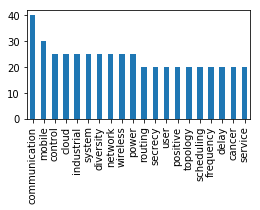

In [115]:
import matplotlib.pyplot as plt
words = pd.DataFrame(words)
words.iloc[:,0].value_counts().head(n=20).plot(kind='bar',figsize=(4,2))
plt.show()

# Topic Analysis

In [109]:
def check_same_topic(topic1, topic2):
    minimum_length = len(topic2) / 1.5
    return len(list(set(topic1) & set(topic2))) >= minimum_length

        

In [188]:
all_topics = []
for i in range(1993, 1998):
    all_topics += topic_dict[i]
len(all_topics)

15

In [189]:
def get_benchmark(all_topics):
    all_temp = all_topics[:]
    benchmark = []
    while all_temp:
        first = all_temp[0]
        all_temp.remove(first)
        benchmark.append(first)
        for element in all_temp:
            if check_same_topic(first, element):
                all_temp.remove(element)
    return benchmark

benchmark = get_benchmark(all_topics)
len(benchmark)

11

In [89]:
def compare_benchmark(benchmark, topic_dict):
    benchmark_count = [0 for i in range(len(benchmark))]
    benchmark_words = [[] for i in range(len(benchmark))]
    for key in topic_dict:
        for topic in topic_dict[key]:
            for i in range(len(benchmark)):
                if check_same_topic(benchmark[i], topic):
                    benchmark_count[i] += 1
                    benchmark_words[i] += topic
    cleaned_benchmark_words = []
    for words in benchmark_words:
        counter={}
        for word in words:
            if word in counter:
                counter[word] += 1
            else:
                counter[word] = 1
        popular_words = sorted(counter, key = counter.get, reverse = True)[:10]
        cleaned_benchmark_words.append(", ".join(popular_words))
    return benchmark_count, cleaned_benchmark_words

In [190]:
benchmark_count, benchmark_words = compare_benchmark(benchmark, topic_dict)

In [91]:
def get_top_topics(num, benchmark_count, benchmark_words):
    benchmark = pd.DataFrame({'Counts':benchmark_count, 'Words':benchmark_words}).sort_values('Counts', ascending=False).iloc[:num,:]
    return benchmark

In [191]:
pd.options.display.max_colwidth = 100
top_topics = get_top_topics(10, benchmark_count, benchmark_words)
top_topics

,Counts,Words
0,3,"set, classification, hyperspectral, color, image, detection, learning, recognition, visualizatio..."
2,2,"control, three-phase, battery, harmonic, frequency, voltage, inverter, antenna, capacitance, diode"
5,2,"control, load, battery, communication, energy, stability, frequency, voltage, array, ratio"
7,2,"classification, color, image, detection, learning, recognition, visualization, saliency, feature..."
1,1,"code, correction, decoder, coding, bound, rate, improvement, binary, compression, decoding"
3,1,"semantic, classification, color, image, preserving, deep, relation, learning, high-level, extract"
4,1,"protocol, computing, communication, energy, spectrum, streaming, cost, radio, scheduling, cloud"
6,1,"partial, mobility, iterative, formulation, centralized, threshold, dual, convex, polynomial, spe..."
8,1,"six, force, 2-d, cancer, torque, surface, distortion, tissue, insertion, skin"
9,1,"protocol, computing, communication, image, streaming, video, scheduling, cloud, information, net..."


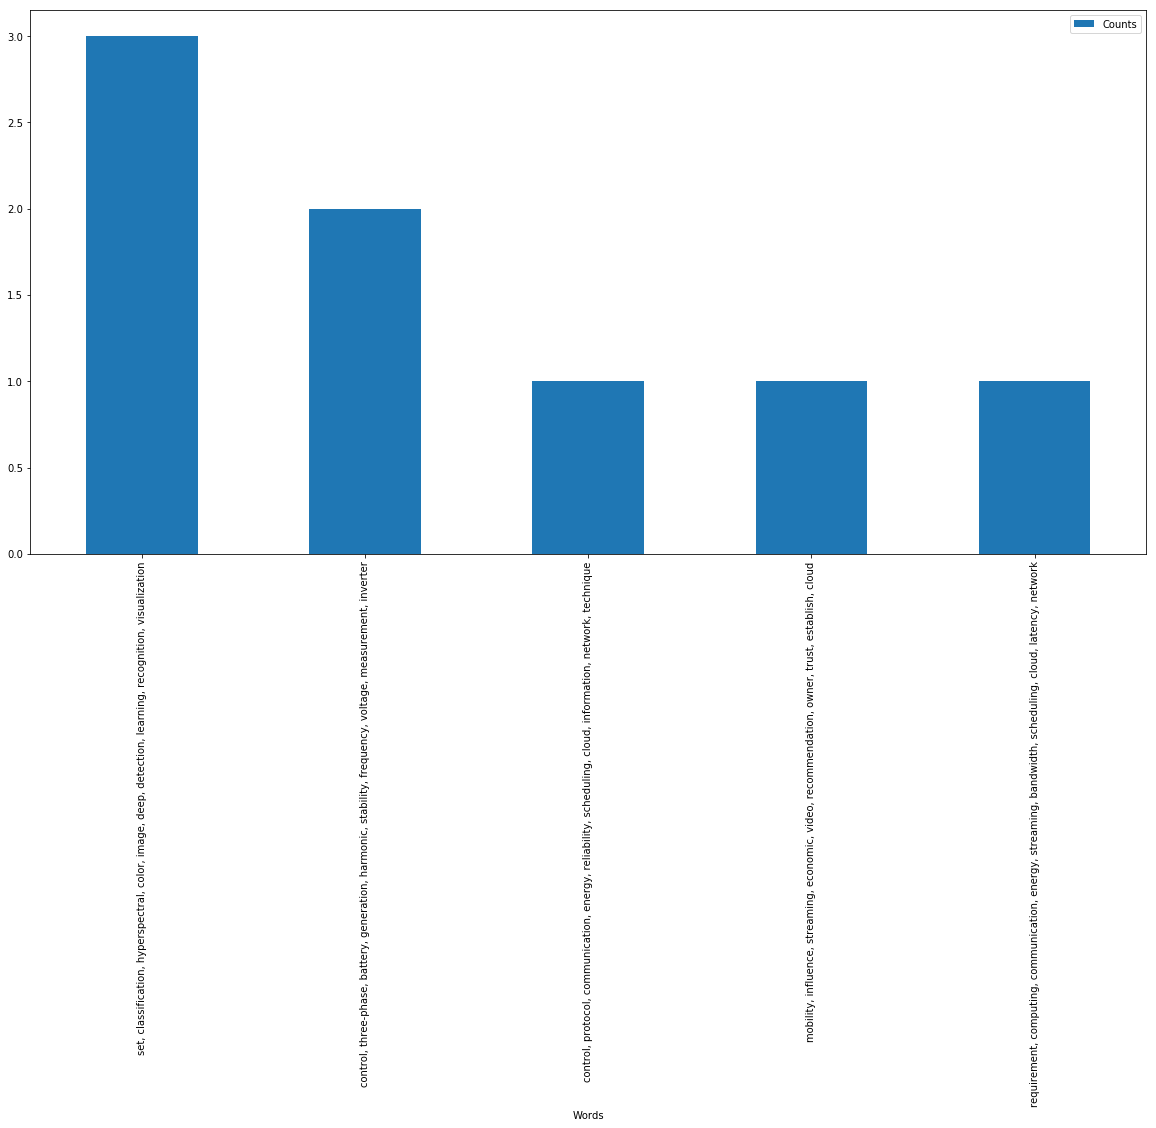

In [93]:
top_topics.plot(x="Words", y="Counts", kind='bar',figsize=(20,10))
plt.show()